In [15]:
STRATEGIES_ORDER = {
    'Baseline': 0,
    'Salt&Pepper': 1,
    'Gaussian': 2,
    'DefaultAug': 3,
    'DefaultAug+Gaussian': 4,
    'DefaultAug+S&P': 5,
    'Mixed': 6,
}

FILENAME = 'official_10folds_results_resnet50_xception'

In [16]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

marker_styles = ['o', 's', '^', 'v', '<', '>', 'p']
sns.set_style("whitegrid")
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"],
})

In [17]:
results = pd.read_csv(f'../results/cifar10/{FILENAME}.csv')

results['evaluation_set'] = results['evaluation_set'].str.replace(' ', '_').str.lower()
results['evaluation_set'] = results['evaluation_set'].str.replace('-', '_').str.lower()
characterization_df = pd.read_csv('../results/cifar10/cifar_10_c_divergences_categories.csv')
characterization_df['corruption_type'] = characterization_df['corruption_type'].str.replace(' ', '_').str.lower()
merged_results = results.merge(
    characterization_df[['corruption_type', 'category']],
    left_on='evaluation_set',
    right_on='corruption_type',
    how='left'
)
merged_results['Severity'] = np.where(
    merged_results['evaluation_set'] == 'in_distribution',
    'In-Distribution',
    merged_results['category']
)
merged_results.drop(columns=['corruption_type'], inplace=True)
merged_results.drop(columns=['category'], inplace=True)
results = merged_results


results['evaluation_set'] = results['evaluation_set'].str.replace(' 1', '')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 2', '')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 3', '')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 4', '')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 5', '')


results_ood = results[results['evaluation_set'] != 'In-Distribution']
results_ood.loc[:, 'evaluation_set'] = 'Out-of-Distribution'

results_in = results[results['evaluation_set'] == 'In-Distribution']
results_in.loc[:, 'Severity'] = 'In-Distribution'


In [18]:
replications = []
for index in range(10):
  if index < 9:
    a = np.arange(1, 11)
    a = np.delete(a, [index, index+1])
    replications.append(a)
      
replications

[array([ 3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 1,  4,  5,  6,  7,  8,  9, 10]),
 array([ 1,  2,  5,  6,  7,  8,  9, 10]),
 array([ 1,  2,  3,  6,  7,  8,  9, 10]),
 array([ 1,  2,  3,  4,  7,  8,  9, 10]),
 array([ 1,  2,  3,  4,  5,  8,  9, 10]),
 array([ 1,  2,  3,  4,  5,  6,  9, 10]),
 array([ 1,  2,  3,  4,  5,  6,  7, 10]),
 array([1, 2, 3, 4, 5, 6, 7, 8])]

In [19]:
def generate_miscoverage(df):
  global_10fold_df = df.copy()
  each_replication_array = []
  for i, selected_folds in enumerate(replications):
      splitted_dataframe = global_10fold_df[global_10fold_df['fold'].isin(selected_folds)].copy()
      splitted_dataframe['replication'] = i + 1
      each_replication_array.append(splitted_dataframe)

  each_replication_df = pd.concat(each_replication_array, ignore_index=True)

  each_leave1out_df = []
  
  for i, selected_folds in enumerate(replications):
      splitted_dataframe = each_replication_df[each_replication_df['fold'].isin(selected_folds)].copy()
      mean_fscore_overall = each_replication_df.groupby(['strategy', 'model', 'replication', 'Severity'])['f1-score(weighted avg)'].mean()

      def normalize_fscore(row):
          fscore = row['f1-score(weighted avg)']
          mean = mean_fscore_overall[row['strategy'], row['model'], row['replication'], row['Severity']]
          return fscore - mean

      dataframe = pd.DataFrame({
          'model': splitted_dataframe['model'],
          'replication': splitted_dataframe['replication'],
          'fold': splitted_dataframe['fold'],
          'severity': splitted_dataframe['Severity'],
          'evaluation_set': splitted_dataframe['evaluation_set'],
          'strategy': splitted_dataframe['strategy'] + '_' + str(i),
          'f1-score(weighted avg)': splitted_dataframe.apply(normalize_fscore, axis=1),
      })
      each_leave1out_df.append(dataframe)

  result_dataframe = pd.concat(each_leave1out_df, ignore_index=True)
  result_dataframe['sort_key'] = (result_dataframe['strategy']
                                  .apply(lambda strategy: STRATEGIES_ORDER[strategy.split('_')[0]]))
  result_dataframe_final = result_dataframe.sort_values(by=['sort_key', 'strategy']).drop(columns=['sort_key'])

  return result_dataframe_final, each_leave1out_df

In [20]:
result_dataframe_in, each_dataframe_fscore_in = generate_miscoverage(results_in)
result_dataframe_in['severity'] = 'In-Distribution'
result_dataframe_ood, each_dataframe_fscore_ood = generate_miscoverage(results_ood)


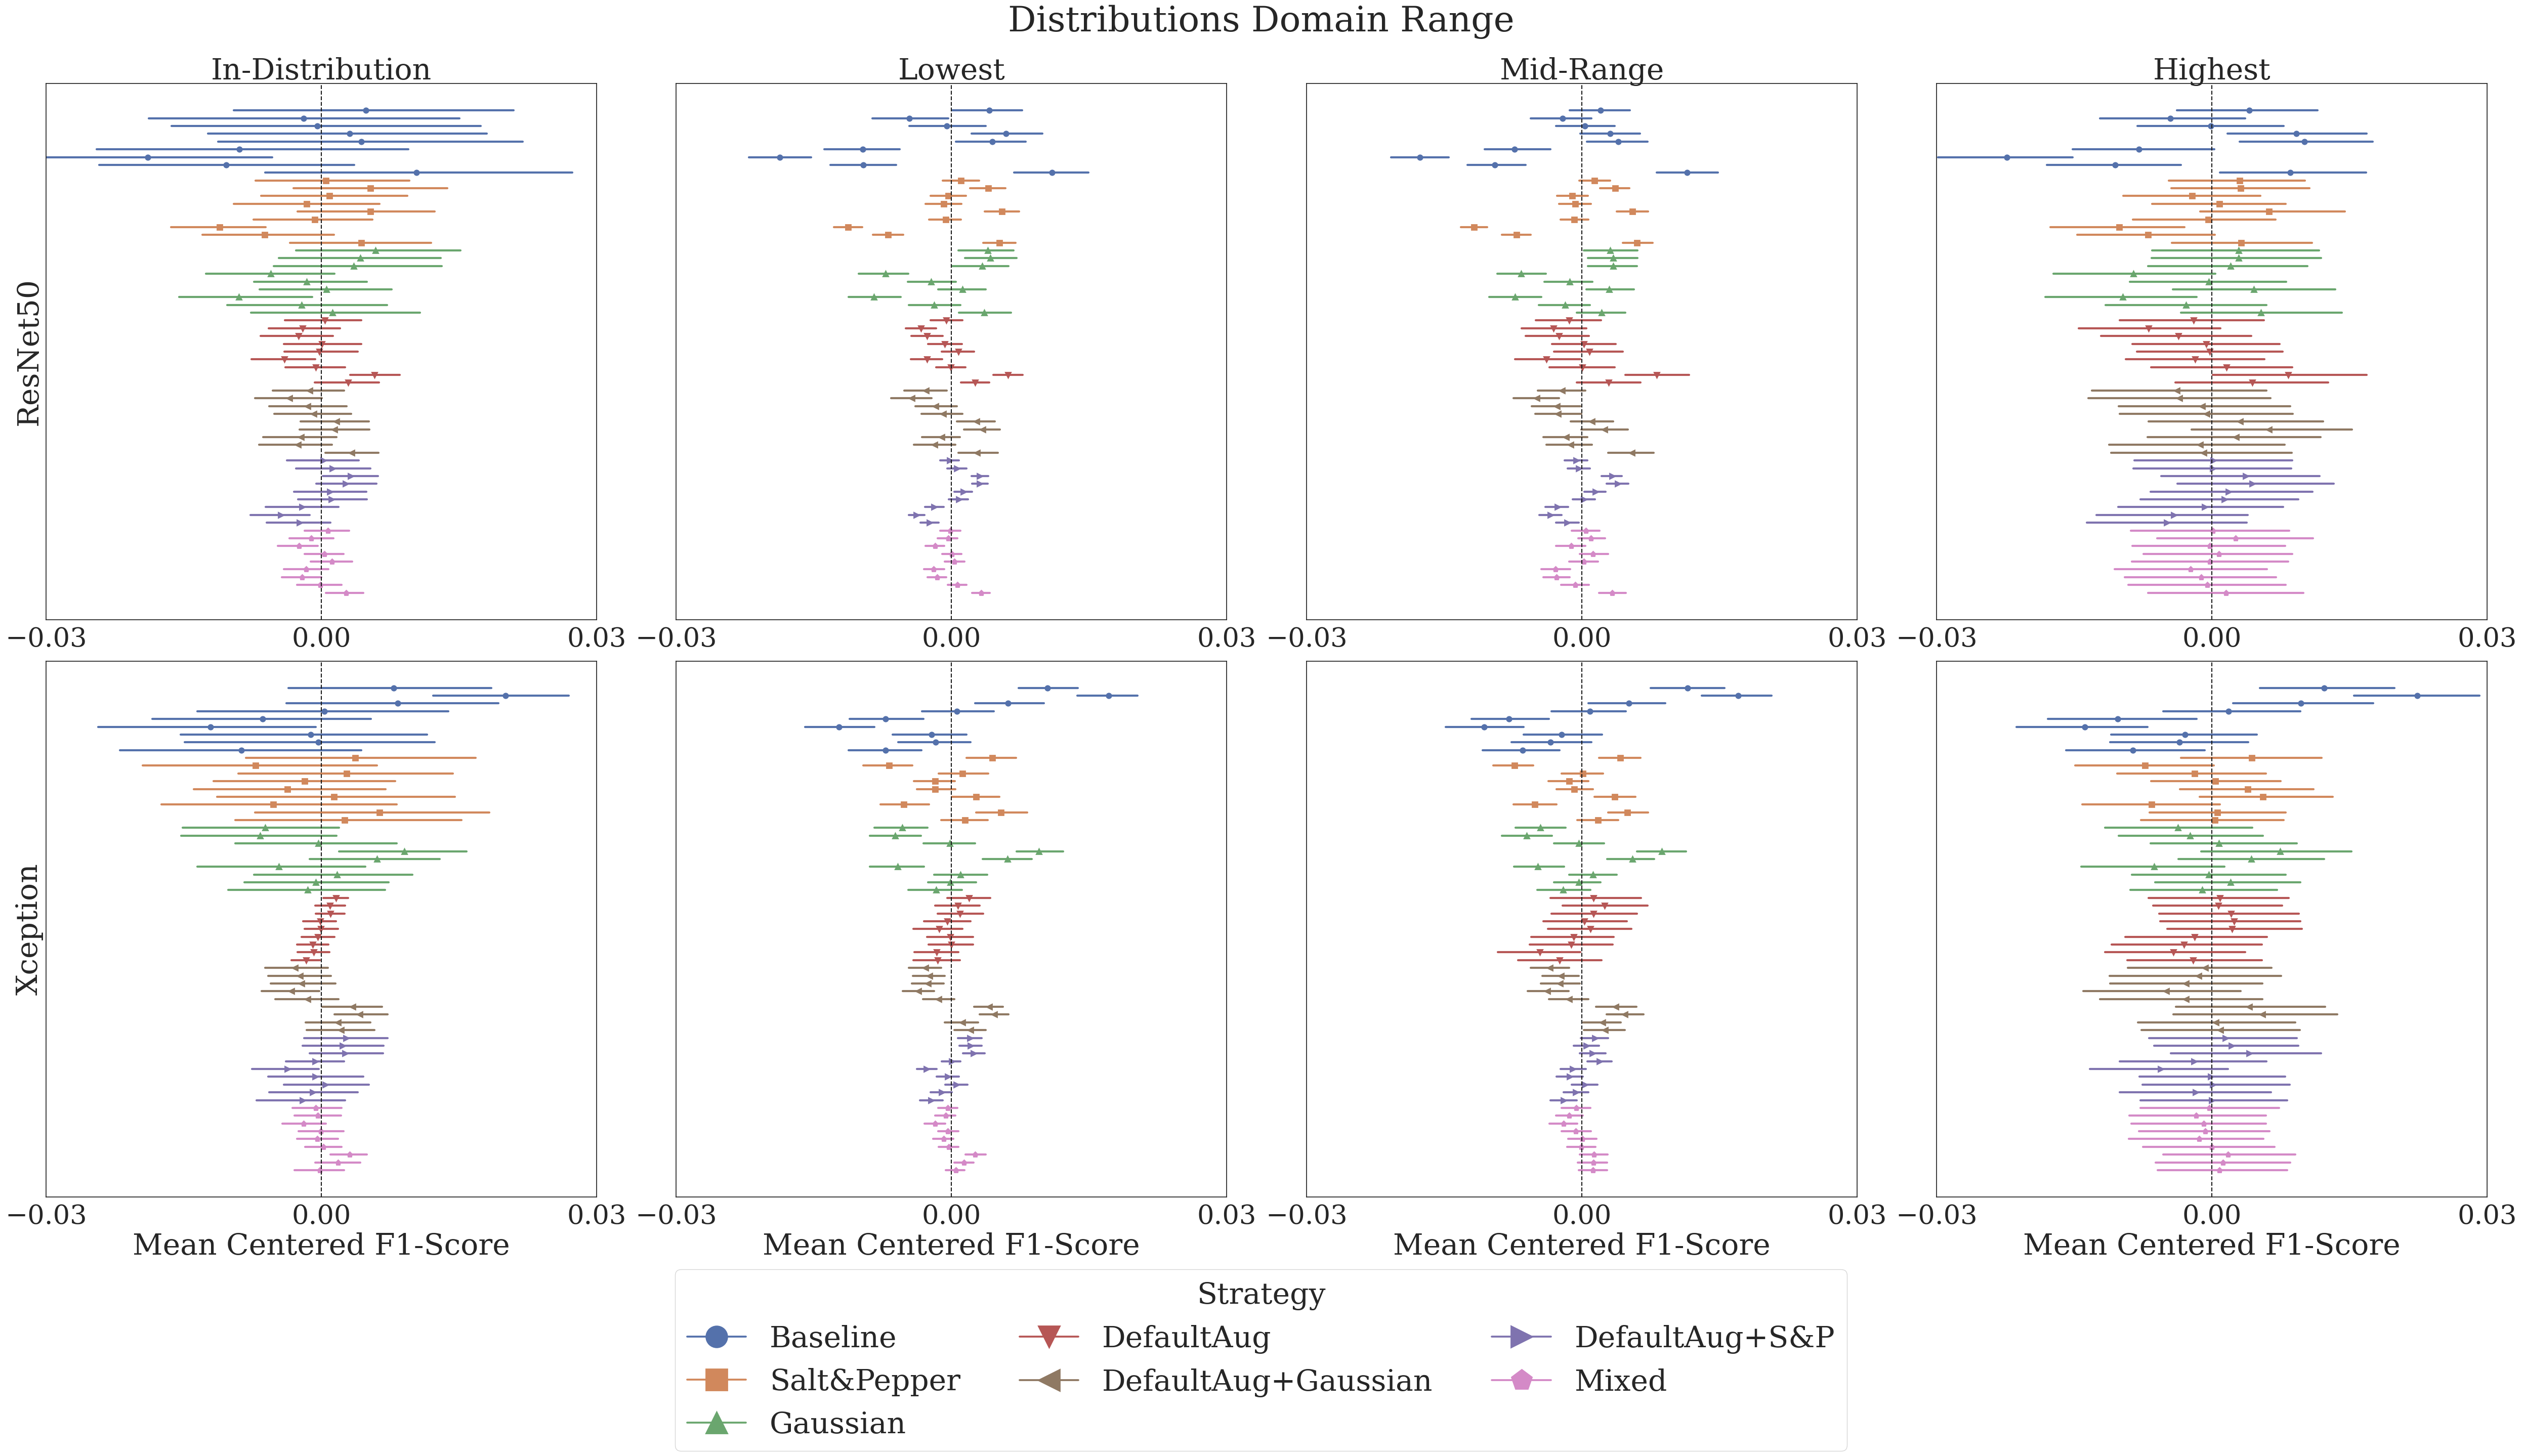

In [21]:
def plot_results_all(df_in, df_out, x_label='Mean Centered F-Score', figsize=(50, 25)):
    unique_values1 = df_in['model'].unique()
    unique_values2 = df_out['model'].unique()
    
    resnet_results_in = df_in[df_in['model'] == unique_values1[0]]
    xception_results_in = df_in[df_in['model'] == unique_values1[1]]
    resnet_results_out = df_out[df_out['model'] == unique_values2[0]]
    xception_results_out = df_out[df_out['model'] == unique_values2[1]]
    
    resnet_results_lowest_dist = resnet_results_out[resnet_results_out['severity'] == 'Lowest']
    resnet_results_midrange_dist = resnet_results_out[resnet_results_out['severity'] == 'Mid-Range']
    resnet_results_highest_dist = resnet_results_out[resnet_results_out['severity'] == 'Highest']
    
    xception_results_lowest_dist = xception_results_out[xception_results_out['severity'] == 'Lowest']
    xception_results_midrange_dist = xception_results_out[xception_results_out['severity'] == 'Mid-Range']
    xception_results_highest_dist = xception_results_out[xception_results_out['severity'] == 'Highest']
    
    fig, axes = plt.subplots(2, 4, figsize=figsize)  # Create a figure with four subplots

    x_min = -.03
    x_max = .03

    x_ticks = [x_min, 0, x_max]

    handles = []
    labels = []

    unique_approaches = df_in['strategy'].unique()
    palette_dict = {}

    for strategy in unique_approaches:
        if strategy not in palette_dict:
            if strategy.split('_')[0] == 'Baseline':
                palette_dict['Baseline'] = '#5471ab'
            elif strategy.split('_')[0] == 'Gaussian':
                palette_dict['Gaussian'] = '#6aa66e'
            elif strategy.split('_')[0] == 'Salt&Pepper':
                palette_dict['Salt&Pepper'] = '#d1885c'
            elif strategy.split('_')[0] == 'DefaultAug+S&P':
                palette_dict['DefaultAug+S&P'] = '#7f73af'
            elif strategy.split('_')[0] == 'DefaultAug+Gaussian':
                palette_dict['DefaultAug+Gaussian'] = '#8f7963'
            elif strategy.split('_')[0] == 'DefaultAug':
                palette_dict['DefaultAug'] = '#b65655'
            elif strategy.split('_')[0] == 'Mixed':
                palette_dict['Mixed'] = '#D48AC7'

    strategy = df_in.copy()
    palette = [palette_dict[strategy.split('_')[0]] for strategy in strategy['strategy'].unique()]

    for i, plot in enumerate([
        {"df": resnet_results_in, "model": "ResNet50", "ylabel": "In-Distribution"},
        {"df": resnet_results_lowest_dist, "model": "ResNet50", "ylabel": "Lowest"},
        {"df": resnet_results_midrange_dist, "model": "ResNet50", "ylabel": "Mid-Range"},
        {"df": resnet_results_highest_dist, "model": "ResNet50", "ylabel": "Highest"},
        {"df": xception_results_in, "model": "Xception", "ylabel": "In-Distribution"},
        {"df": xception_results_lowest_dist, "model": "Xception", "ylabel": "Lowest"},
        {"df": xception_results_midrange_dist, "model": "Xception", "ylabel": "Mid-Range"},
        {"df": xception_results_highest_dist, "model": "Xception", "ylabel": "Highest"},
    ]):
        ax = sns.pointplot(
            data=plot['df'],
            x='f1-score(weighted avg)',
            y='severity',
            hue='strategy',
            linestyles='none',  # Set line style for error bars
            markers=['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
                     's', 's', 's', 's', 's', 's', 's', 's', 's',
                     '^', '^', '^', '^', '^', '^', '^', '^', '^',
                     'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
                     '<', '<', '<', '<', '<', '<', '<', '<', '<',
                     '>', '>', '>', '>', '>', '>', '>', '>', '>',
                     'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
            errorbar=("ci", 95),
            dodge=.9,
            palette=palette, 
            err_kws={'linewidth': 3},
            ax=axes[i // 4, i % 4]
        )
                
        ax.set_xlabel(x_label, fontsize=32)

        ax.set_xlim(x_min, x_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks([])

        ax.axvline(x=0, color='k', linestyle='--')
        
        if i == 0 or i == 1 or i == 2 or i == 3:
            ax.set_xlabel("")
            ax.set_title(plot['ylabel'], fontsize=42)
        else:
            ax.set_xlabel("Mean Centered F1-Score", fontsize=42)
            
            
        if i == 0:
            ax.set_ylabel("ResNet50", fontsize=42)
        elif i == 4:
            ax.set_ylabel("Xception", fontsize=42)
        else:
            ax.set_ylabel('')


        ax.tick_params(labelsize=38)

        ax.legend_.remove()

        if i == 0:
            handles, labels = ax.get_legend_handles_labels()


    for i in range(len(labels)):
        labels[i] = labels[i].split('_')[0]

    unique_labels = []
    unique_handles = []
    for i, label in enumerate(labels):
        if label not in unique_labels:     
            unique_labels.append(label)
            unique_handles.append(handles[i]) 
                
    for i, handle in enumerate(unique_handles):
        handle.set_marker(marker_styles[i % len(marker_styles)])
        handle.set_markersize(30)

    fig.legend(unique_handles, unique_labels, title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.155), fontsize=42, title_fontsize=42, ncol=3)
    fig.suptitle('Distributions Domain Range', fontsize=50, y=1)
    plt.tight_layout()
    plt.savefig('../output/miscoverage_plot.pdf', bbox_inches='tight')
    plt.show()

plot_results_all(result_dataframe_in, result_dataframe_ood)

In [22]:
def bootstrap_confidence_interval(data, num_samples=1000, ci=0.95):
    data = np.array(data)

    res = stats.bootstrap((data,), np.std, confidence_level=ci, n_resamples=num_samples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

In [23]:
df = pd.concat(each_dataframe_fscore_in + each_dataframe_fscore_ood)

for model in ['ResNet50', 'Xception']:
    print('\n')
    for strategy in ['Baseline', 'Gaussian', 'Salt&Pepper', 'DefaultAug_', 'DefaultAug+Gaussian_', 'DefaultAug+S&P_', 'Mixed']:
        curr_df = df[(df['model'] == model) & (df['strategy'].str.startswith(strategy))]
        
        # Group by severity and calculate stats
        for severity, severity_df in curr_df.groupby('severity'):
            lower, upper = bootstrap_confidence_interval(severity_df['f1-score(weighted avg)'])
            print(f"STD {model} - {strategy} - Severity {severity}: {severity_df['f1-score(weighted avg)'].std()} ({lower}, {upper})")



STD ResNet50 - Baseline - Severity Highest: 0.14605382661835467 (0.14426666674891792, 0.14807243328248004)
STD ResNet50 - Baseline - Severity In-Distribution: 0.06353211548672956 (0.06083736353547364, 0.06628669249596214)
STD ResNet50 - Baseline - Severity Lowest: 0.07332474073429297 (0.07237723878310189, 0.07422562363412223)
STD ResNet50 - Baseline - Severity Mid-Range: 0.08915890978218162 (0.08828157533532784, 0.08994696232603962)
STD ResNet50 - Gaussian - Severity Highest: 0.16809202128248021 (0.166037869114684, 0.1701598340880776)
STD ResNet50 - Gaussian - Severity In-Distribution: 0.03164450354719362 (0.030095605316154614, 0.03314317015189105)
STD ResNet50 - Gaussian - Severity Lowest: 0.052639819210449 (0.051827350788224216, 0.05343916347758762)
STD ResNet50 - Gaussian - Severity Mid-Range: 0.07248011783726772 (0.07184649111393439, 0.07314679089345523)
STD ResNet50 - Salt&Pepper - Severity Highest: 0.14513750406560574 (0.1430448328205705, 0.14701018704926785)
STD ResNet50 - Sal